In [2]:
# For Google Colab use
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd '/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder'    
except ModuleNotFoundError:
    pass

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MLP-DeepfakeDetection-VariationalAutoencoder


In [3]:
# Imports
from __future__ import division

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from numpy.random import seed

import tensorflow as tf

import keras
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import *
from keras.applications import *
from keras import metrics
from keras.losses import binary_crossentropy
from keras import backend as K

# !pip install -U keras-tuner
# from kerastuner.tuners import RandomSearch, Hyperband
# from kerastuner.engine.hypermodel import HyperModel
# from kerastuner.engine.hyperparameters import HyperParameters
# from kerastuner import Objective

In [4]:
# Check GPU available
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [77]:
# General model settings
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 140, 140, 3
EPOCHS = 300
DATA_GENERATOR_SEED = 1337
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
# LEARNING_RATE = 1e-3
LATENT_DIM = 1024

tf.random.set_seed(DATA_GENERATOR_SEED)
seed(DATA_GENERATOR_SEED)

# Pick dataset; DF_TYPE={'rnd-30', 'avg-30'}
DF_TYPE = 'avg-30'
TRAIN_VAL_DIR = f'./Celeb-DF-v2/Celeb-{DF_TYPE}'
TEST_DIR = f'{TRAIN_VAL_DIR}-test'

# TRAIN_VAL_DIR += '/Celeb-real'
# TEST_DIR += '/Celeb-real'

TRAIN_VAL_DIR, TEST_DIR

('./Celeb-DF-v2/Celeb-avg-30', './Celeb-DF-v2/Celeb-avg-30-test')

In [78]:
TRAIN_DATAGEN = ImageDataGenerator(rescale = 1.0/255.0,
                                #    rotation_range = 20,
                                #    width_shift_range = 0.2,
                                #    height_shift_range = 0.2,
                                #    shear_range = 0.15,
                                #    zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode='nearest',
                                   validation_split = VALIDATION_SPLIT)
TRAIN_GENERATOR = TRAIN_DATAGEN.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary', 
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    subset = 'training',
                                                    seed = DATA_GENERATOR_SEED)


VAL_DATAGEN = ImageDataGenerator(rescale = 1.0/255.0, validation_split = VALIDATION_SPLIT)
VALIDATION_GENERATOR = TRAIN_DATAGEN.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'binary', 
                                                         target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         subset = 'validation',
                                                         seed = DATA_GENERATOR_SEED)


TEST_DATAGEN = ImageDataGenerator(rescale = 1.0/255.0)
TEST_GENERATOR = TEST_DATAGEN.flow_from_directory(directory = TEST_DIR,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'binary', 
                                                  target_size = (IMG_HEIGHT, IMG_WIDTH),                                
                                                  seed = DATA_GENERATOR_SEED)

Found 49942 images belonging to 2 classes.
Found 5548 images belonging to 2 classes.
Found 19638 images belonging to 2 classes.


In [79]:
# Random sampling function for latent vector, z; "variational part"
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [80]:
# Encoder
encoder_inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Batch
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Sampling
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

# Defining full encoder as keras model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=5, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Defining full encoder as keras model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder_outputs

In [81]:
# VAE summary
encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 70, 70, 32)   896         input_36[0][0]                   
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 35, 35, 64)   18496       conv2d_102[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 78400)        0           conv2d_103[0][0]                 
____________________________________________________________________________________________

In [82]:
# Build VAE model as custom (keras model class) class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(data, reconstruction),
                              axis=(1, 2)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

In [83]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

(x_train, _) = TRAIN_GENERATOR.next()
(x_test, _) = VALIDATION_GENERATOR.next()
training_data = np.concatenate([x_train, x_test], axis=0)
training_data = np.expand_dims(training_data, -1).astype("float32") / 255
training_data = training_data[:, :, :, :, 0]

vae.fit(training_data,
        epochs=1000,
        batch_size=BATCH_SIZE)

Epoch 1/1000
2/2 [==============================] - 5s 91ms/step - loss: 13570.0996 - reconstruction_loss: 13563.9307 - kl_loss: 0.0013
Epoch 2/1000
2/2 [==============================] - 0s 94ms/step - loss: 13488.4430 - reconstruction_loss: 13480.2080 - kl_loss: 0.0110
Epoch 3/1000
2/2 [==============================] - 0s 92ms/step - loss: 13369.0521 - reconstruction_loss: 13355.8711 - kl_loss: 0.2216
Epoch 4/1000
2/2 [==============================] - 0s 90ms/step - loss: 13177.0736 - reconstruction_loss: 13153.8145 - kl_loss: 1.6501
Epoch 5/1000
2/2 [==============================] - 0s 89ms/step - loss: 12838.5579 - reconstruction_loss: 12791.0234 - kl_loss: 6.8968
Epoch 6/1000
2/2 [==============================] - 0s 87ms/step - loss: 12129.8057 - reconstruction_loss: 12015.5479 - kl_loss: 22.7573
Epoch 7/1000
2/2 [==============================] - 0s 90ms/step - loss: 10544.3643 - reconstruction_loss: 10294.1387 - kl_loss: 67.5882
Epoch 8/1000
2/2 [============================

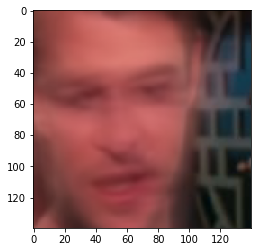

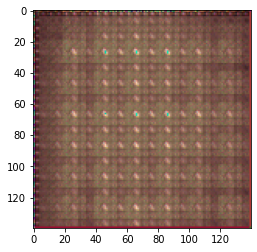

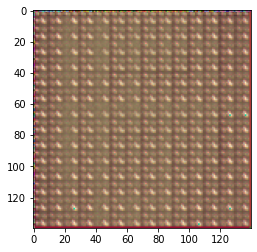

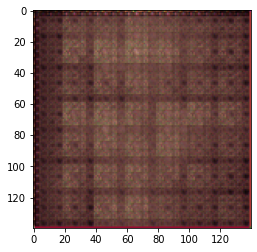

In [86]:
X = np.expand_dims(x_test[0], axis=0)

plt.figure()
plt.imshow(X.squeeze())
Z = vae.encoder.predict(X)
for z in Z:
    X_primed = vae.decoder.predict(z)
    face = X_primed.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    face = np.array(face*255*225, dtype=np.uint8)
    
    plt.figure()
    plt.imshow(face)

In [29]:
import numpy             as np
import matplotlib.pyplot as plt
import keras.backend     as K

from keras.models       import Sequential
from keras.layers       import Dense
from keras.layers       import BatchNormalization
from keras.layers       import Reshape
from keras.layers       import UpSampling2D
from keras.layers       import Convolution2D
from keras.layers       import Activation
from keras.layers       import Flatten
from keras.layers       import AveragePooling2D
from keras.optimizers   import Adam
from keras.datasets     import mnist

In [57]:
encoding_size = 1024

In [59]:
encoder = Sequential([
    Convolution2D(16, 3, strides=1, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(32, 3, strides=2, padding='same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(64, 3, strides=1, padding='same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(32, 3, strides=2, padding='same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(encoding_size),
    Activation('tanh')
])

decoder = Sequential([
    Dense(49, input_shape = (encoding_size,)),
    BatchNormalization(),
    Activation('relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(3, (3, 3), padding = 'same', activation = 'tanh')
])

In [60]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer=Adam(), loss='mse')

In [50]:
(x_train, _) = TRAIN_GENERATOR.next()
(x_test, _) = VALIDATION_GENERATOR.next()
training_data = np.concatenate([x_train, x_test], axis=0)
training_data = np.expand_dims(training_data, -1).astype("float32") / 255
training_data = training_data[:, :, :, :, 0]

In [51]:
autoencoder.fit(x_train,
                x_train,
                batch_size=128,
                epochs=10,
                verbose = 2)

Epoch 1/10


ValueError: ignored

(28, 28, 3)

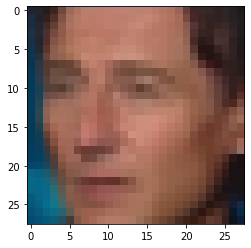

In [105]:
X = x_train[3]
pic = plt.imshow(X, cmap = 'gray')
X.shape

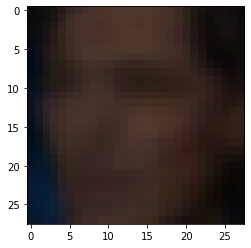

In [108]:
X_primedd = autoencoder.predict(np.expand_dims(X, axis=0))
X_primedd = X_primedd.squeeze() * 100
X_primedd = X_primedd.astype('int8') 
plt.imshow(X_primedd, cmap = 'gray')

In [ ]:
'___'

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')